In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
PATH_TRAIN = "/content/drive/MyDrive/Dokship_AI_Challange/Dataset/Classification_Dataset/Training_Dataset/Classification_Dataset/Training_Data/"

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 128 # or try size 256
IMG_WIDTH = 128 # or try size 256
CHANNELS = 3

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size = [IMG_HEIGHT, IMG_WIDTH])

  return image

(128, 128, 3)


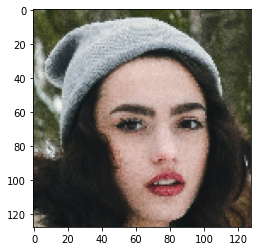

In [5]:
import numpy as np
re = load(PATH_TRAIN+'Fake_Images/hard_226_0100.jpg')
plt.figure()
plt.imshow(re/255.0)
print(re.shape)

In [6]:
data_dir_list = os.listdir(PATH_TRAIN)
data_dir_list

['Real_Images', 'Fake_Images']

In [7]:
img_data_list = []
image_path_list = []

In [8]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH_TRAIN+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH_TRAIN+dataset+'/'+img
        image_path_list.append(img_path)
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, size = [IMG_HEIGHT, IMG_WIDTH])
        img_data_list.append(image)
        count = count+1
        if count == 700:
          break

  1%|          | 10/861 [00:00<00:09, 91.50it/s]

Loading the images of dataset - Real_Images



  1%|▏         | 10/760 [00:00<00:07, 97.72it/s]

Loading the images of dataset - Fake_Images



 92%|█████████▏| 698/760 [00:06<00:00, 104.35it/s]


In [9]:
img_data = np.array(img_data_list)
img_data = img_data
print(img_data.shape)

(1400, 128, 128, 3)


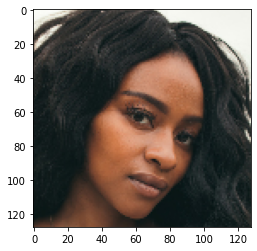

In [10]:
plt.imshow(img_data[500]/255)

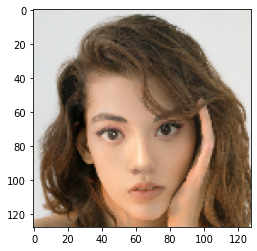

In [11]:
plt.imshow(img_data[1100]/255)

In [12]:
img_data.dtype

dtype('float32')

In [13]:
num_classes = 2
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [14]:
labels[:700] = 0
labels[700:] = 1

names = ['Real_Images', 'Fake_Images']

labels.shape

(1400,)

In [15]:
#Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,labels, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1)

In [16]:
print(X_train.shape)
print(y_train.shape)

(1260, 128, 128, 3)
(1260,)


In [17]:
print(X_test.shape)
print(y_test.shape)

(140, 128, 128, 3)
(140,)


Classification Model

In [18]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [19]:
initializer = tf.random_normal_initializer(0., 0.02)

inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
down4 = downsample(256, 4)(down2) # (bs, 16, 16, 256)

zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 18, 18, 256)
conv1 = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 15, 15, 512)
batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
leaky_relu1 = tf.keras.layers.LeakyReLU()(batchnorm1)

zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu1) # (bs, 17, 17, 512)
conv2 = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad2) # (bs, 14, 14, 512)
batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
leaky_relu2 = tf.keras.layers.LeakyReLU()(batchnorm2)


flatten = tf.keras.layers.Flatten()(leaky_relu1)

dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_initializer=initializer)(flatten)
dense2 = tf.keras.layers.Dense(units = 256, activation = 'relu', kernel_initializer=initializer)(dense1)
dense3 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer=initializer)(dense2)
#dense4 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer=initializer)(dense3)

out = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense3)


Classifier_Model = tf.keras.Model(inputs = inp,  outputs=out)

In [20]:
opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
Classifier_Model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

In [22]:
Classifier_Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 64)        3072      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 128)       131584    
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 256)       525312    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 512)       2097152   
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 512)       2048  

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('Fake_Face_Detector.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [24]:
history = Classifier_Model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/30
40/40 [==============================] - 6s 75ms/step - loss: 0.9386 - accuracy: 0.5114 - val_loss: 0.9549 - val_accuracy: 0.5143
Epoch 2/30
40/40 [==============================] - 3s 62ms/step - loss: 0.6616 - accuracy: 0.6274 - val_loss: 2.7879 - val_accuracy: 0.5071
Epoch 3/30
40/40 [==============================] - 2s 62ms/step - loss: 0.5912 - accuracy: 0.6911 - val_loss: 0.8131 - val_accuracy: 0.5643
Epoch 4/30
40/40 [==============================] - 2s 63ms/step - loss: 0.4117 - accuracy: 0.8153 - val_loss: 0.7639 - val_accuracy: 0.6071
Epoch 5/30
40/40 [==============================] - 2s 63ms/step - loss: 0.2316 - accuracy: 0.9132 - val_loss: 0.8658 - val_accuracy: 0.5071
Epoch 6/30
40/40 [==============================] - 2s 62ms/step - loss: 0.1057 - accuracy: 0.9703 - val_loss: 0.8891 - val_accuracy: 0.5929
Epoch 7/30
40/40 [==============================] - 2s 62ms/step - loss: 0.0366 - accuracy: 0.9940 - val_loss: 1.3047 - val_accuracy: 0.5357
Epoch 8/30
40

In [25]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


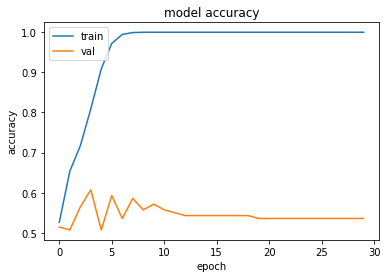

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'][0:50])
plt.plot(history.history['val_accuracy'][0:50])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

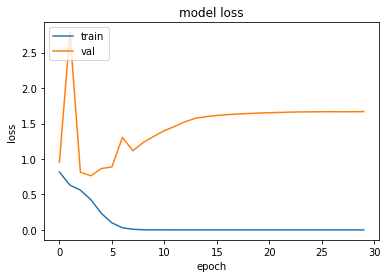

In [27]:
# summarize history for loss
plt.plot(history.history['loss'][0:50])
plt.plot(history.history['val_loss'][0:50])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()